# SchW-BERT-GAN 事前学習
Theorytabデータセットを使用
- 前処理済みのデータセットからバッチ生成器を作成
- ハイパーパラメータを記入した設定ファイルを作成
- ConditionalBertBodyモジュールの定義
- 事前学習フレームワークと事前学習モジュールの作成
- 事前学習の実行と結果の表示・保存

In [1]:
import os, time, math, json, random
import datetime
import hickle as hkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.normalization import LayerNorm
from torch.utils.data import Dataset, random_split
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from pypianoroll import Track, Multitrack
from utils import Timer, grid_plot
from bundle import Bundle

current dir: /root/schwbert


In [2]:
base_dir = "../datasets"
schwbert_dir = os.path.join(base_dir, "schwbert")

input_dir = os.path.join(schwbert_dir, "data", "theorytab")
input_path = os.path.join(input_dir, "original.hkl")

output_base_dir = os.path.join(schwbert_dir, "models")
output_dir = os.path.join(output_base_dir, "theorytab")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

# 前処理済みのtheorytabデータセットからバッチ生成器を作成
DataLoaderとDatasetの扱い方はQiitaを[参照](https://qiita.com/takurooo/items/e4c91c5d78059f92e76d)

その前にまずは前処理済みデータをロード

In [3]:
with Timer():
     bundle_list = hkl.load(input_path)
print(len(bundle_list))

310.901330
17396


DataLoaderへ渡すTheorytabDatasetを作成

In [4]:
class TheorytabDataset(Dataset):
    def __init__(self, bundles, include_meta=True):
        self.data = bundles
        self.data_num = len(bundles)
        self.include_meta = include_meta
    
    def add_note_areas_to_meta(self, include_rest=True):
        # ステップを音符ごとに分ける
        for b, bundle in enumerate(self.data):
            note_areas = []
            last_pitch = None
            lowest, highest = bundle['meta']['melody_pitch_range']
            rest_id = bundle['meta']['melody_pitch_rest']
            
            for step, pitch in enumerate(bundle['melody']):
                if (lowest <= pitch <= highest) or (include_rest and pitch == rest_id):
                    if last_pitch != pitch:
                        note_areas.append([])
                    note_areas[-1].append(step)
                last_pitch = pitch
                    
            self.data[b]['meta']['note_areas'] = note_areas
    
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        melody = self.data[idx]['melody']
        chord = self.data[idx]['chord']
        
        if self.include_meta:
            meta = self.data[idx]['meta']
            return melody, chord, meta
        else:
            return melody, chord
    
    def split(self, rates, shuffle=False):
        assert(sum(rates) == 1.)
        
        all_data_ids = list(range(self.data_num))
        if shuffle:
            random.shuffle(all_data_ids)
        
        sizes = [int(self.data_num * rate) for rate in rates[:-1]]
        sizes.append(self.data_num - sum(sizes))
        
        partial_dataset_list = []
        last_right = 0
        for size in sizes:
            left, right = last_right, last_right+size
            last_right += size
            partial_data = [self.data[idx] for idx in all_data_ids[left:right]]
            dataset = TheorytabDataset(partial_data, self.include_meta)
            partial_dataset_list.append(dataset)
        
        return partial_dataset_list

torchのDataLoaderはmeta辞書の中身をバッチで結合して1つの辞書にしてきやがる  
バッチにしたときmeta辞書はindexと対応するようにしたいので，DataLoaderを自作

In [5]:
class TheorytabDataLoader:
    def __init__(self, theorytab_dataset, batch_size, shuffle=False):
        self.dataset = theorytab_dataset
        self.idx_list = list(range(len(self.dataset)))
        self.include_meta = self.dataset.include_meta
        assert(batch_size >= 1)
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def make_batch(self, melody_batch, chord_batch, meta_batch):
        # 一度np.arrayをかませてからLongTensorに渡すと爆速になったので採用
        # しかしバッチサイズが1000くらい大きくならないと同じ速度にならない
        melody_batch, chord_batch = np.array([melody_batch, chord_batch])
        batch = {
            'melody': torch.LongTensor(melody_batch),
            'chord': torch.LongTensor(chord_batch),
            'meta': meta_batch # AttrDictを通すとlistではなくtupleになるので注意
        }
        return AttrDict(batch)
    
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.idx_list)

        melody_batch, chord_batch, meta_batch = [], [], []
        for idx in self.idx_list:

            if self.include_meta:
                melody, chord, meta = self.dataset[idx]
                meta_batch.append(meta)
            else:
                melody, chord = self.dataset[idx]

            melody_batch.append(melody)
            chord_batch.append(chord)

            if len(melody_batch) >= self.batch_size:
                yield self.make_batch(melody_batch, chord_batch, meta_batch)
                melody_batch, chord_batch, meta_batch = [], [], []

        if melody_batch and chord_batch and meta_batch:
            yield self.make_batch(melody_batch, chord_batch, meta_batch)
    
    def __call__(self):
        """
        何でもいいからバッチが欲しい時使う
        ジェネレータを返すわけではないので注意
        """
        return next(self.__iter__())

In [6]:
dataset = TheorytabDataset(bundle_list)
with Timer():
    dataset.add_note_areas_to_meta()

11.829031


In [7]:
dataloader = TheorytabDataLoader(dataset, batch_size=2, shuffle=True)
print(len(dataloader))

8698


In [8]:
train_dataset, val_dataset, test_dataset = dataset.split([0.8, 0.17, 0.03], shuffle=True)
print("train size :", len(train_dataset))
print("val   size :", len(val_dataset))
print("test  size :", len(test_dataset))

train size : 13916
val   size : 2957
test  size : 523


動作確認

In [9]:
with Timer():
    batch = dataloader()
print(batch.melody.type())
print(batch.melody.size())
print(batch.chord.type())
print(batch.chord.size())
print(len(batch.meta))

0.026290
torch.LongTensor
torch.Size([2, 768])
torch.LongTensor
torch.Size([2, 768])
2


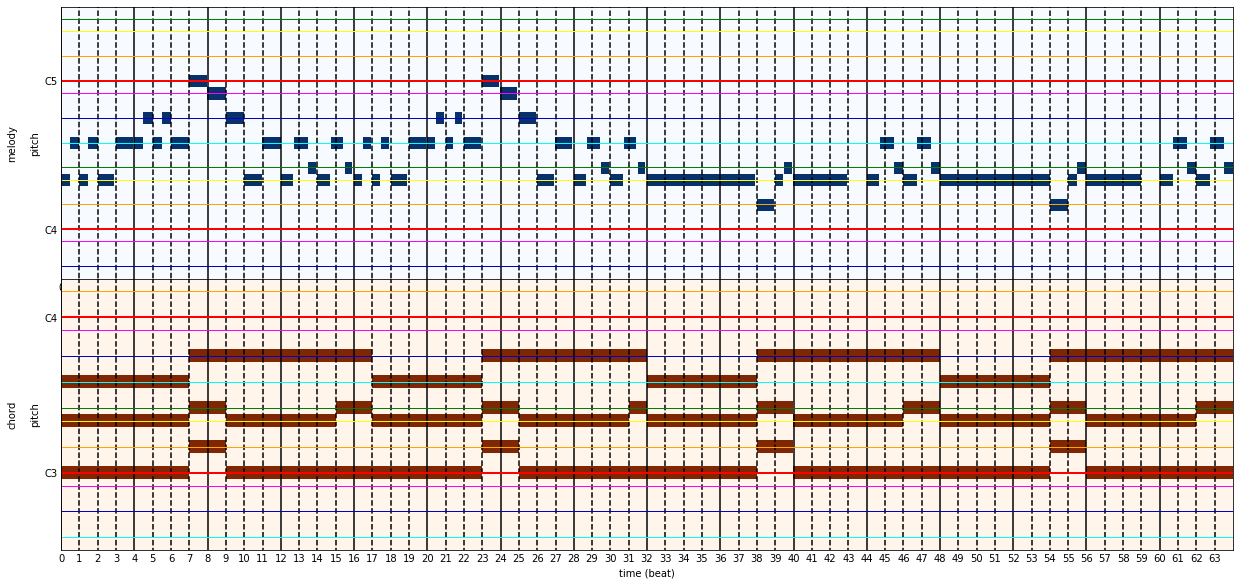

In [10]:
batch_id = 0
bundle = Bundle({
    "melody": batch.melody[batch_id],
    "chord": batch.chord[batch_id],
    "meta": batch.meta[batch_id]
})
ppr = bundle.get_ppr()
grid_plot(ppr)

# ハイパーパラメータを記入した設定辞書を作成

In [11]:
rep = dataloader()
rep_meta = AttrDict(rep.meta[0])

In [12]:
config = {
    'nickname': "original",
    'step_num': rep.melody[0].shape[0],
    'beat_resolution': rep_meta.beat_resolution,
    'beats_in_bar': rep_meta.beats_in_bar,
    'bar_num': rep_meta.bars,
    'melody_pitch_range': [int(i) for i in rep_meta.melody_pitch_range],
    'melody_mask_id': rep_meta.melody_pitch_mask,
    'melody_rest_id': rep_meta.melody_pitch_rest,
    'melody_pad_id': rep_meta.melody_pitch_pad,
    'melody_vocab_size': rep_meta.melody_vocab_size,
    'chord_pad_id': rep_meta.chord_pitch_pad,
    'chord_vocab_size': rep_meta.chord_vocab_size,
    'hidden_size': 32,
    'intermediate_size': 32 * 4,
    'attention_layer_num': 12,
    'attention_head_num': 4,
    'dropout_prob': 0.1,
    'adam_lr': 1e-5,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'pre_mnp_rate': 0.15,
    'pre_mnp_mask_rate': 0.80,
    'pre_mnp_random_rate': 0.10,
    'pre_mnp_keep_rate': 0.10,
}
config = AttrDict(config)
for item in config.items():
    print(f"{item[0]}: {item[1]}")

nickname: original
step_num: 768
beat_resolution: 12
beats_in_bar: 4
bar_num: 16
melody_pitch_range: [0, 64]
melody_mask_id: 65
melody_rest_id: 64
melody_pad_id: 66
melody_vocab_size: 67
chord_pad_id: 4096
chord_vocab_size: 4097
hidden_size: 32
intermediate_size: 128
attention_layer_num: 12
attention_head_num: 4
dropout_prob: 0.1
adam_lr: 1e-05
adam_beta1: 0.9
adam_beta2: 0.999
pre_mnp_rate: 0.15
pre_mnp_mask_rate: 0.8
pre_mnp_random_rate: 0.1
pre_mnp_keep_rate: 0.1


# ConditionalBertBodyの作成
事前学習を行い，他のタスク用モジュールへ連結するためのbodyモジュール  
コードは[ここ](https://nbviewer.jupyter.org/github/fuurin/pytorch_advanced/blob/master/Chapter8/8-2_bert_base.ipynb)を参照

実装するものはこれ  
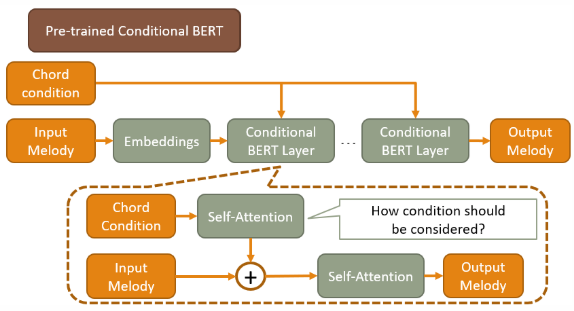

基本となるBERT Layerモジュールはこれ  
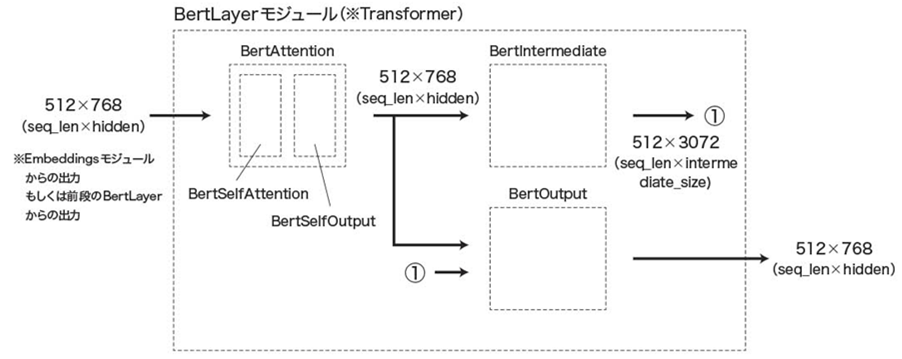

画像： 書籍「つくりながら学ぶ! PyTorchによる発展ディープラーニング」（小川雄太郎、マイナビ出版 、19/07/29)  
公式リポジトリ https://github.com/YutaroOgawa/pytorch_advanced

#### Conditional Bertにするための変更点
ChordConditionをBertAttentionに通した出力をAとする  
AとInputMelodyをBertOutputのような加算＋正規化モジュールへ送った出力をBとする  
BをBertAttentionへ送り，後は同じ  
なお，クラス分類用のPoolerは今回の生成タスクでは使用しないので実装しない  
代わりに小節ごとの情報をまとめるPoolerを作るか？
  
ChordConditionにもEmbedding欲しいかなぁ

## Embeddingsモジュールの実装
- Embeddings
    - MelodyEmbeddings
    - ChordEmbeddings
        - IDで渡ってこないので，EmbeddingsではなくDenseで実装

Embeddingsは意味のある区切りを与えることが多い模様  
それに倣って，音楽版のEmbeddingsは4つで行ってみよう！
- input_embedding: ピッチID/コードベクトルのEmbedding
- step_embedding: range(seq_len)を与えるEmbedding
- beat_embedding: 0から始まる拍番号を各ステップへ与える
- bar_embedding: 0から始まる小節番号を各ステップへ与える

とりあえず埋め込みは学習対象パラメータにする  
埋め込みベクトルのサイズは…  
一般的に語彙が多すぎるから圧縮するわけなんだけど，MIDIだとそんなに多くない  
ここは4, 12, 24, 48, 64辺りを試してみるか  
んで，事前学習が上手くいくかどうか，GANで生成する曲がよくなるかを見る  
一般的なメロディの音程は2オクターブ前後なので，まずは24で試してみるか

In [13]:
class MusicEmbeddings(nn.Module):
    def __init__(self, config, vocab_size, pad_id=0):
        super(MusicEmbeddings, self).__init__()
        
        # EmbeddingLayer: (入力の種類数, 組込ベクトルサイズ)
        # 48とかのIDを受け取ってone-hot vectorと解釈して組込ベクトルへ変換する
        self.hidden_size = config.hidden_size
        self.beat_res = config.beat_resolution
        self.step_num = config.step_num
        self.beat_num = config.beats_in_bar * config.bar_num
        self.bar_num = config.bar_num
        self.bar_step_num = config.beats_in_bar * self.beat_res
        
        self.input_embeddings = nn.Embedding(
            vocab_size,
            self.hidden_size, # 24
            padding_idx=pad_id
        )
        
        self.step_embeddings = nn.Embedding(
            self.step_num,   # 768
            self.hidden_size # 24
        )
        
        self.beat_embeddings = nn.Embedding(
            self.beat_num,   # 64
            self.hidden_size # 24
        )
        
        self.bar_embeddings = nn.Embedding(
            self.bar_num,    # 16
            self.hidden_size # 24 ここはむしろEmbeddingのほうが大きくなってしまっている...
        )
        
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def add_fixed_embeddings(self, input_emb):
        # step ID -> ステップ埋め込みベクトル
        step_ids = torch.arange(self.step_num, dtype=torch.float32) # 0~767
        step_ids = step_ids.unsqueeze(0).expand(input_emb.shape[:-1]) # バッチ用の次元を追加
        step_ids = step_ids.to(input_emb.device)
        step_emb = self.step_embeddings(step_ids.type(torch.long))
        
        # beat ID -> 拍埋め込みベクトル
        # 同じ数がbeat_res個続くようにする
        beat_ids = torch.floor(step_ids.clone() / self.beat_res)
        beat_emb = self.beat_embeddings(beat_ids.type(torch.long))
        
        # bar ID -> 小節埋め込みベクトル
        # 同じ数がbar_step_num個続くようにする
        bar_ids = torch.floor(step_ids.clone() / self.bar_step_num)
        bar_emb = self.bar_embeddings(bar_ids.type(torch.long))
        
        # 4つの埋め込みベクトルを足し合わせる
        # (batch_size, step_num, hidden_size)
        embeddings = input_emb + step_emb + beat_emb + bar_emb
        
        return embeddings
    
    def post_layers(self, tensor):
        tensor = self.norm(tensor)
        tensor = self.dropout(tensor)
        return tensor
    
    def forward(self, input_ids):
        # input_ids: (batch_size, step_num)の文章中の単語ID列
        
        # input ID -> 入力埋め込みベクトル
        input_emb = self.input_embeddings(input_ids)
        
        # ステップ，拍，小節の埋め込みベクトルを加算
        embeddings = self.add_fixed_embeddings(input_emb)
                
        # 埋め込みベクトルを正規化 & Dropout
        embeddings = self.post_layers(embeddings)
        
        return embeddings

class MelodyEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(MelodyEmbeddings, self).__init__(config, config.melody_vocab_size, config.melody_pad_id)

class ChordEmbeddings(MusicEmbeddings):
    def __init__(self, config):
        super(ChordEmbeddings, self).__init__(config, config.chord_vocab_size, config.chord_pad_id)

動作確認

In [14]:
batch = dataloader()

print(batch.melody.shape)
print(batch.chord.shape)

melody_embeddings = MelodyEmbeddings(config)
chord_embeddings = ChordEmbeddings(config)

melody_emb = melody_embeddings(batch.melody)
chord_emb = chord_embeddings(batch.chord)

print("melody_emb shape:", melody_emb.shape)
print("chord_emb shape:", chord_emb.shape)

torch.Size([2, 768])
torch.Size([2, 768])
melody_emb shape: torch.Size([2, 768, 32])
chord_emb shape: torch.Size([2, 768, 32])


## ConditionalBertAttentionモジュールの実装
以下のサブネットワークを持つ
- ConditionalBertAttention: Conditionを考慮したSelf-Attentionを計算
    - Multi-Head: 1, 2, 4, 8, とりあえず4から試すか
    - ここでpadをかける
- BertIntermediate: Self-Attentionの出力を全結合層で処理
    - 全結合層の活性化関数にGELU（Gaussian error Linear Unit, 入力0付近の出力が滑らか)を使う
- BertOutput: BertAttentionとBertIntermediateの出力を足し算

### ConditionalBertAttentionモジュールの作成
次のサブモジュールからなる
- condition_attn(BertSelfAttention)
- conditioning(BertSelfConditioning, BertSelfOutputとほぼ同じ)
- attn(BertSelfAttention)
- output(BertOutput)

In [15]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        
        self.hidden_size = config.hidden_size # 24
        self.attention_head_num = config.attention_head_num # 4
        self.attention_head_size = self.hidden_size // self.attention_head_num # 6
        
        # Self-Attentionの特徴量を作成する全結合層
        self.query = nn.Linear(self.hidden_size, self.hidden_size)
        self.key = nn.Linear(self.hidden_size, self.hidden_size)
        self.value = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def separate_into_heads(self, single):
        # multi-head attention用にテンソルの形を変換
        # [batch, steps, hidden] -> [batch, head_num, steps, head_size]
        multi_shape = single.size()[:-1] + (self.attention_head_num, self.attention_head_size)
        multi = single.view(*multi_shape).permute(0, 2, 1, 3)
        return multi
    
    def extend_pad(self, pad, paded_value=-10000.0):
        # multi-head attention用にpadの形を(batch, 1, 1, step_num)にする
        extended_pad = pad.unsqueeze(1).unsqueeze(2) # multi-headに次元を対応
        extended_pad = (1.0 - extended_pad) * paded_value
        extended_pad = extended_pad.to(dtype=torch.float32)
        return extended_pad
    
    def marge_heads(self, multi):
        # multi-head attentionに分離したテンソルの形を元に戻す
        # [batch, head_num, steps, head_size] -> [batch, steps, hidden]
        multi = multi.permute(0, 2, 1, 3).contiguous()
        single_shape = multi.size()[:-2] + (self.hidden_size,)
        single = multi.view(*single_shape)
        return single
    
    def forward(self, hidden_states, pad, get_probs=False):
        
        # 入力を全結合層で特徴量変換(分岐前)
        marged_query = self.query(hidden_states)
        marged_key = self.key(hidden_states)
        marged_value = self.value(hidden_states)
        
        # multi-head Attentionとして分岐
        queries = self.separate_into_heads(marged_query)
        keyes = self.separate_into_heads(marged_key)
        values = self.separate_into_heads(marged_value)
        
        # 特徴量同士の類似度を求める
        scores = torch.matmul(queries, keyes.transpose(-1, -2))
        scores = scores / math.sqrt(self.attention_head_size) # Scaled Dot-Product Attention
        
        # マスクをかける
        # 足し算なのは，attention_padに0か-infが入っているため
        # -infはsoftmax正規化したときに0になる
        scores = scores + self.extend_pad(pad)
        
        # AttentionMapの正規化とドロップアウト
        probs = nn.Softmax(dim=-1)(scores)
        probs = self.dropout(probs)
        
        # Attenton Mapをvalueに掛け算
        contexts = torch.matmul(probs, values)
        
        # multi-head Attentionの出力を結合
        context = self.marge_heads(contexts)
        
        if get_probs:
            return context, probs
        else:
            return context

In [16]:
class BertSelfConditioning(nn.Module):
    def __init__(self, config):
        super(BertSelfConditioning, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, condition_tensor):
        conditioned_states = self.dense(hidden_states + condition_tensor)
        conditioned_states = self.dropout(conditioned_states)
        conditioned_states = self.norm(conditioned_states)
        return conditioned_states

In [17]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.norm = LayerNorm(config.hidden_size, eps=1e-8)
        self.dropout = nn.Dropout(config.dropout_prob)
    
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.norm(hidden_states + input_tensor)
        return hidden_states

In [18]:
class ConditionalBertAttention(nn.Module):
    def __init__(self, config):
        super(ConditionalBertAttention, self).__init__()
        self.condition_attn = BertSelfAttention(config)
        self.conditioning = BertSelfConditioning(config)
        self.attn = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        
        if get_probs:
            condition, condition_probs = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output, probs = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            return output, probs, condition_probs
        else:
            condition = self.condition_attn(condition_tensor, condition_pad, get_probs)
            conditioned_tensor = self.conditioning(input_tensor, condition)
            output = self.attn(conditioned_tensor, input_pad, get_probs)
            output = self.output(output, input_tensor) # or conditioned_tensor?
            return output

In [19]:
def make_pad(ids, pad_id):
    return (ids != pad_id).to(torch.float32)

動作確認

In [20]:
batch = dataloader()

print(batch.melody.shape)
print(batch.chord.shape)

melody_pad = make_pad(batch.melody, config.melody_pad_id)
chord_pad = make_pad(batch.chord, config.chord_pad_id)

melody_embeddings = MelodyEmbeddings(config)
chord_embeddings = ChordEmbeddings(config)
attention = ConditionalBertAttention(config)

melody_emb = melody_embeddings(batch.melody)
chord_emb = chord_embeddings(batch.chord)

get_probs=True
if get_probs:
    output, probs, c_probs = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)
    print("probs shape:", probs.shape)
    print("conditional probs shape:", c_probs.shape)
else:
    output = attention(melody_emb, chord_emb, melody_pad, chord_pad, get_probs=get_probs)
    print("output shape:", output.shape)

torch.Size([2, 768])
torch.Size([2, 768])
output shape: torch.Size([2, 768, 32])
probs shape: torch.Size([2, 4, 768, 768])
conditional probs shape: torch.Size([2, 4, 768, 768])


### BertIntermediateモジュールの実装

In [21]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [22]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu
    
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

### BertOutputモジュールの実装

In [23]:
class BertOutput(BertSelfOutput):
    def __init__(self, config):
        super(BertOutput, self).__init__(config)        
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)

### ConditionalBertLayerモジュールの実装

In [24]:
class ConditionalBertLayer(nn.Module):
    def __init__(self, config):
        super(ConditionalBertLayer, self).__init__()
        self.attn = ConditionalBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
    
    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, get_probs=False):
        if get_probs:
            output, probs, c_probs = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output, probs, c_probs
        else:
            output = self.attn(input_tensor, condition_tensor, input_pad, condition_pad, get_probs)
            intermediate_output = self.intermediate(output)
            output = self.output(intermediate_output, output)
            return output

### ConditionalBertStackモジュールの実装
Embeddingとは分離してパラメータを保存したいため，Stackの部分をモジュール化  
padはidsからつくるため，bodyで作る

In [25]:
class ConditionalBertStack(nn.Module):
    def __init__(self, config):
        super(ConditionalBertStack, self).__init__()
        self.layer_num = config.attention_layer_num    
        attention_list = [ConditionalBertLayer(config) for _ in range(self.layer_num)]
        self.attention_list = nn.ModuleList(attention_list)
    
    def forward(self, input_tensor, condition_tensor, input_pad, condition_pad, 
                get_all_outputs=False, get_probs=False):
        
        all_outputs, all_probs, all_c_probs = [], [], []
        
        for attention in self.attention_list:
            if get_probs:
                input_tensor, probs, c_probs = attention(
                    input_tensor, condition_tensor, 
                    input_pad, condition_pad, 
                    get_probs=get_probs)
            else:
                input_tensor = attention(
                    input_tensor, condition_tensor, 
                    input_pad, condition_pad, 
                    get_probs=get_probs)
                
            # 12段すべての出力を見る場合
            if get_all_outputs:
                all_outputs.append(input_tensor)
                if get_probs:
                    all_probs.append(probs)
                    all_c_probs.append(c_probs)
                
        # 最終段のAttentionのみ必要な場合
        if not get_all_outputs:
            all_outputs = input_tensor
            if get_probs:
                all_probs = probs
                all_c_probs = c_probs
        
        if get_probs:
            return (all_outputs, all_probs, all_c_probs)
        else:
            return all_outputs

## ConditionalBertBodyの実装
embeddingsはあとでノイズ発生器に置き換えたりできるのでattention_listとは別に保存できるようにする

In [26]:
class ConditionalBertBody(nn.Module):
    def __init__(self, config, input_embeddings, condition_embeddings, input_pad_id, condition_pad_id):
        super(ConditionalBertBody, self).__init__()
        self.config = config
        self.input_pad_id = input_pad_id
        self.condition_pad_id = condition_pad_id
        self.input_embeddings = input_embeddings
        self.condition_embeddings = condition_embeddings
        self.conditional_bert_stack = ConditionalBertStack(config)
    
    def make_pad(self, ids, pad_id):
        pad = (ids != pad_id).to(torch.float32)
        pad = pad.to(ids.device)
        return pad
    
    def forward(self, input_tensor, condition_tensor, get_all_outputs=False, get_probs=False):
        input_pad = self.make_pad(input_tensor, self.input_pad_id)
        condition_pad = self.make_pad(condition_tensor, self.condition_pad_id)
        input_tensor = self.input_embeddings(input_tensor)
        condition_tensor = self.condition_embeddings(condition_tensor)
        stack_out = self.conditional_bert_stack(
                        input_tensor, condition_tensor,
                        input_pad, condition_pad,
                        get_all_outputs, get_probs)
        return stack_out        

動作確認

In [27]:
device = torch.device("cpu")

batch = dataloader()
batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)
print(batch.melody.shape)
print(batch.chord.shape)

melody_emb = MelodyEmbeddings(config)
chord_emb = ChordEmbeddings(config)
body = ConditionalBertBody(config, melody_emb, chord_emb,
                           input_pad_id=config.melody_pad_id,
                           condition_pad_id=config.chord_pad_id)
body = body.to(device)

get_probs = True
get_all_outputs = True
if get_probs:
    output, probs, c_probs = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
        print("probs len:", len(probs))
        print("conditional probs len:", len(c_probs))
    print("output shape:", (output[0] if get_all_outputs else output).shape)
    print("probs shape:", (probs[0] if get_all_outputs else probs).shape)
    print("conditional probs shape:", (c_probs[0] if get_all_outputs else c_probs).shape)
else:
    output = body(batch.melody, batch.chord, get_all_outputs, get_probs)
    if get_all_outputs:
        print("output len:", len(output))
    print("output shape:", (output[0] if get_all_outputs else output).shape)

torch.Size([2, 768])
torch.Size([2, 768])
output len: 12
probs len: 12
conditional probs len: 12
output shape: torch.Size([2, 768, 32])
probs shape: torch.Size([2, 4, 768, 768])
conditional probs shape: torch.Size([2, 4, 768, 768])


bodyのパラメータ数を確認してみる

In [30]:
trainable_params_num = sum(p.numel() for p in body.parameters() if p.requires_grad)
print("trainable params:", trainable_params_num)
# print(body)

trainable params: 391552


増える量的に，多くのパラメータは埋め込みに使われている模様  
しかしhidden_sizeが増えるともちろん爆上がりする

# 事前学習フレームワークと各事前学習モジュールの作成

## 事前学習フレームワークの作成
事前学習フレームワークは以下の動作が主な役割である
- body,DataLoader,事前学習クラスのリストを渡す
    - 入力データとラベルの作成
    - bodyと事前学習モジュールを連結
    - 入力データを連結モジュールへ与える
    - 出力とラベルからロスをBP

事前学習クラスは以下を持つ
- 入力データとラベルの作成関数
- 事前学習モジュールの定義関数
- 損失関数

In [31]:
class PreTrainingModel(nn.Module):
    def __init__(self, config, body):
        super(PreTrainingModel, self).__init__()
        self.config = config
        self.body = body
        self.loss_dict = {'train': [], 'val': []}
        self.acc_dict = {'train': [], 'val': []}
    
    def forward_head(self, body_output):
        raise NotImplementedError()
        
    def get_data_and_label(self, batch):
        raise NotImplementedError()
    
    @property
    def condition_str(self):
        raise NotImplementedError()

## 各事前学習クラスの作成
事前学習はひとまず3種類
- Masked Note Prediction (虫食い音符の穴埋め)
    - 1ステップごとではなく，音符一つごとMASKして穴埋め
    - 休符も1つの音符と数えるべき？
    - ランダムに入れ替えたり，そのままにしたりするのを1割ずつやる
- Bars Order Prediction (小節の順番を学習)
    - 全ての小節をバラバラにして元の楽曲を生成
    - 16 × 16の行列を出力させ，どの小節が何番目にあるべきかを推論
- (Chord) Condition Prediction (元のコード条件を出力メロディから推論)
    - chord ID を出力メロディから推論
    - Chordにカッコがついてるのは，テンポやジャンルといった条件が増えたときにも同様の事前学習をさせられるため

### MaskedNotePredictionの作成
音符単位でマスクしてマスクされている部分を推測する  
[MASK]トークンはファインチューニングの際には出現しないためミスマッチを作ってしまうという弱点がある．  
そこで，マスク対象となった単語を実際の[MASK]には，必ずしも置き換えないことにする．  
  
訓練データ生成器は推論に用いる全体の15%のトークンポジションをランダムに選ぶ．  
$i$番目のトークンが選ばれたとき，$i$番目のトークンを
- (1) 80%の確立で[MASK]に置き換える
- (2) 10%の確立で別のランダムな単語に置き換える
- (3) 10%の確立でそのままのトークンにしておく
    
そして，$i$番目のトークン$T_i$はオリジナルのトークンの推測に使用され，cross entropy lossで損失を得る  
  
衝撃の事実: 事前学習用のデータは固定で，イテレーションの度にマスクされる場所が変更されるわけではなかった  
今回扱うデータは自然言語並みに多様性があるわけではないのでイテレーションの度に変更するようにしてみる

とりあえず全結合2段でMNPしてみよう

マスクされるpositionの数はbundleによってまちまちである  
bertの本家コードでは，max_predictions_per_seqを導入し，この数を超えないようにtokensを選ぶ  
そして，max_predictions_per_seqに満たない部分はposition=0, id=0, weight=0とし，paddingする  
これにより，mwpヘッドへの入力をmax_predictions_per_seq個のトークンに絞る．  
padされているpositionのlossにweight=0をかけてやることで  
上記の処理でマスクされるpositionのみのlossとaccを求める  
コードは本家の[run_pretraining.py](https://github.com/google-research/bert/blob/e13c1f3459cc254f7abbabfc5a286a3304d573e4/run_pretraining.py#L277)及び[create_pretraining_data.py](https://github.com/google-research/bert/blob/0fce551b55caabcfba52c61e18f34b541aef186a/create_pretraining_data.py#L125)が参考になる

In [32]:
class MaskedNotePrediction(PreTrainingModel):
    def __init__(self, config, body, include_rest=True):
        super(MaskedNotePrediction, self).__init__(config, body)
        self.target_rate = config.pre_mnp_rate
        self.mask_rate = config.pre_mnp_mask_rate
        self.random_rate = config.pre_mnp_random_rate
        self.keep_rate = config.pre_mnp_keep_rate
        
        self.max_predict_steps = int(config.step_num * self.target_rate)
        self.hidden_size = config.hidden_size
        self.bar_res = config.beats_in_bar * config.beat_resolution
        self.melody_vocab_size = config.melody_vocab_size
        self.mask_id = config.melody_mask_id
        
        self.melody_pitches = list(range(*config.melody_pitch_range))
        if include_rest:
            self.melody_pitches.append(config.melody_rest_id)
        self.to_one_hot = torch.eye(self.melody_vocab_size)
        
        self.dense_1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.act_1 = gelu
        self.norm_1 = LayerNorm(config.hidden_size, eps=1e-8)
        self.dense_2 = nn.Linear(config.hidden_size, config.melody_vocab_size)
        self.act_2 = gelu
        self.norm_2 = LayerNorm(config.melody_vocab_size, eps=1e-8)
        self.log_softmax = nn.LogSoftmax(dim=0)
    
    def get_data_and_label(self, batch):
        device = batch.melody.device
        batch_num = len(batch.melody)
        
        batch_steps = torch.zeros(
            [batch_num, self.max_predict_steps, self.hidden_size], 
            dtype=torch.long
        ).to(device)
        
        batch_weights = torch.zeros(
            [batch_num, self.max_predict_steps, 1]
        ).to(device)
        
        batch_labels = torch.zeros(
            [batch_num, self.max_predict_steps, self.melody_vocab_size]
        ).to(device)
                
        for b in range(batch_num):
            melody = batch.melody[b]
            
            # ステップを音符ごとに分けたものを取得
            note_areas = batch.meta[b].note_areas
            
            # 音符のIDをランダムにならべかえる
            note_num = len(note_areas)
            target_note_candidates = list(range(note_num))
            random.shuffle(target_note_candidates)

            # マスク処理の対象となる音符を選ぶ．
            # このとき，合計ステップ数がmax_predict_stepsを超えないようにする
            # selfでない方のmax_predict_stepsはoriginal_barsに基づくものなので注意
            song_step_num = self.bar_res * batch.meta[b].original_bars
            max_predict_steps = int(song_step_num * self.target_rate)
            target_note_areas = []
            target_step_num = 0
            for target_note_id in target_note_candidates:
                target_note_area = note_areas[target_note_id]
                if target_step_num + len(target_note_area) <= max_predict_steps:
                    target_note_areas.append(target_note_area)
                    target_step_num += len(target_note_area)

            # 処理の対象となったステップのリスト
            # なんとなくソートしておく
            target_steps = []
            for note_area in target_note_areas:
                target_steps += list(note_area)
            target_steps.sort()
            active_step_len = len(target_steps)
            batch_steps[b, :active_step_len, :] = torch.LongTensor(target_steps).view([-1, 1])
            
            # max_predict_stepsにサイズを合わせるためのweightを用意
            # lossの計算時，padのstepに0, そうでないstepに1をかける
            batch_weights[b, :active_step_len, :] = 1
            
            # 処理の対象となったステップごとの正解ラベル
            one_hot_labels = self.to_one_hot[melody[target_steps]]
            batch_labels[b, :active_step_len, :] = one_hot_labels

            # 対象音符数， マスクされる音符の数， ランダムに変更される音符の数, そのままにされる音符の数を取得
            target_note_num = len(target_note_areas)
            random_num = int(target_note_num * self.random_rate)
            keep_num = int(target_note_num * self.keep_rate)
            masked_num = target_note_num - random_num - keep_num

            # mask対象の音符をmaskにする
            masked_note_areas = target_note_areas[:masked_num] # (音符, ステップ)の二次元配列
            for area in masked_note_areas:
                melody[list(area)] = self.mask_id

            # random対象の音符をランダムに入れ替え
            random_note_areas = target_note_areas[masked_num:masked_num+random_num]
            for area in random_note_areas:
                melody[list(area)] = random.choice(self.melody_pitches)

            # batchのメロディを更新
            batch.melody[b] = melody
        
        return batch, batch_steps, batch_weights, batch_labels
    
    def forward_head(self, body_output, batch_steps):
        # ここでloss計算対象ステップを絞る．
        # body_outputはすでに周囲の情報を考慮しており，
        # 以降のDenseではステップごとに同じ処理が行われるため，
        # targetでない入力を使う必要がない
        # body_output: [2, 765, 24], batch_steps(index): [2, 115, 24], gatherのoutput: [2, 115, 24]
        output = torch.gather(body_output, 1, batch_steps)
        output = self.dense_1(output)
        output = self.act_1(output)
        output = self.norm_1(output)
        output = self.dense_2(output)
        output = self.act_2(output)
        output = self.norm_2(output)
        return output
    
    def get_loss_and_acc(self, model_output, label, weight, eps=1e-8):
        # トークンごとに対象かどうかをweightで選択し，CrossEntropyを求める
        # PytorchのCrossEntropyLossではこれができなそうなので，本家コードに従った処理を行う
        softmax_out = self.log_softmax(model_output)
        weighted_ce_loss = softmax_out * label * weight
        neg_sum_loss = - weighted_ce_loss.sum()
        target_seq_len = weight.sum()
        avg_loss = neg_sum_loss / (target_seq_len + eps)
        
        # model_outputの最大値とlabelからaccuracyを求める
        probs, preds = torch.max(model_output, dim=-1)
        ones, label_ids = torch.max(label, dim=-1)
        weighted_corrects = (preds == label_ids) * weight.squeeze()
        correct_num = weighted_corrects.sum().to(torch.float)
        avg_acc = correct_num / (target_seq_len + eps)
        
        return avg_loss, avg_acc
    
    def forward(self, batch):
        # データ取得 -> bodyのフォワード -> specific task用ヘッドのフォワード -> loss, accの計算
        batch, batch_steps, batch_weights, batch_labels = self.get_data_and_label(batch)
        body_output = self.body(batch.melody, batch.chord)
        model_output = self.forward_head(body_output, batch_steps)
        loss, acc = self.get_loss_and_acc(model_output, batch_labels, batch_weights)        
        return loss, acc
    
    @property
    def condition_str(self):
        T = self.config.pre_mnp_rate
        M = self.config.pre_mnp_mask_rate
        R = self.config.pre_mnp_random_rate
        K = self.config.pre_mnp_keep_rate
        return f"MNP:T={T}M={M}R={R}K={K}"

動作確認

forwardが通るかの確認

In [33]:
device = torch.device('cpu')

batch.melody = batch.melody.to(device)
batch.chord = batch.chord.to(device)

mnp = MaskedNotePrediction(config, body)
mnp = mnp.to(device)

with Timer():
    loss, acc = mnp(batch)

print(loss, acc)

0.496126
tensor(0.7965, grad_fn=<DivBackward0>) tensor(0.0058)


In [34]:
import copy
org_batch = dataloader()
batch = copy.deepcopy(org_batch)
with Timer():
    batch, steps, weights, labels = mnp.get_data_and_label(batch)

0.004225


マスキング情報の確認

In [35]:
batch_id = 0
print("target steps:", steps[batch_id], "\nshape:", steps.shape)
print("target weights shape:", weights.shape)
print("target labels:", labels[batch_id], "\nshape:", labels.shape)
print("target label ids:", np.where(labels[batch_id].numpy())[1])

target steps: tensor([[12, 12, 12,  ..., 12, 12, 12],
        [13, 13, 13,  ..., 13, 13, 13],
        [14, 14, 14,  ..., 14, 14, 14],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]) 
shape: torch.Size([2, 115, 32])
target weights shape: torch.Size([2, 115, 1])
target labels: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
shape: torch.Size([2, 115, 67])
target label ids: [28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 26 26 26 26 26 26 26
 26 26 28 28 28 28 28 28 28 28 28 26 26 26 31 31 31 31 31 31 31 31 31 33
 33 33 33 33 33 33 33 33 64]


マスキング情報の整合性確認

In [36]:
step_sum = (steps[batch_id] > 0).sum()
print(step_sum / config.hidden_size) # -1されるのは0ステップ目が選ばれているとき
print(labels[batch_id].sum())
print(weights[batch_id].sum())

tensor(57)
tensor(57.)
tensor(57.)


マスキングされているか可視化して確認

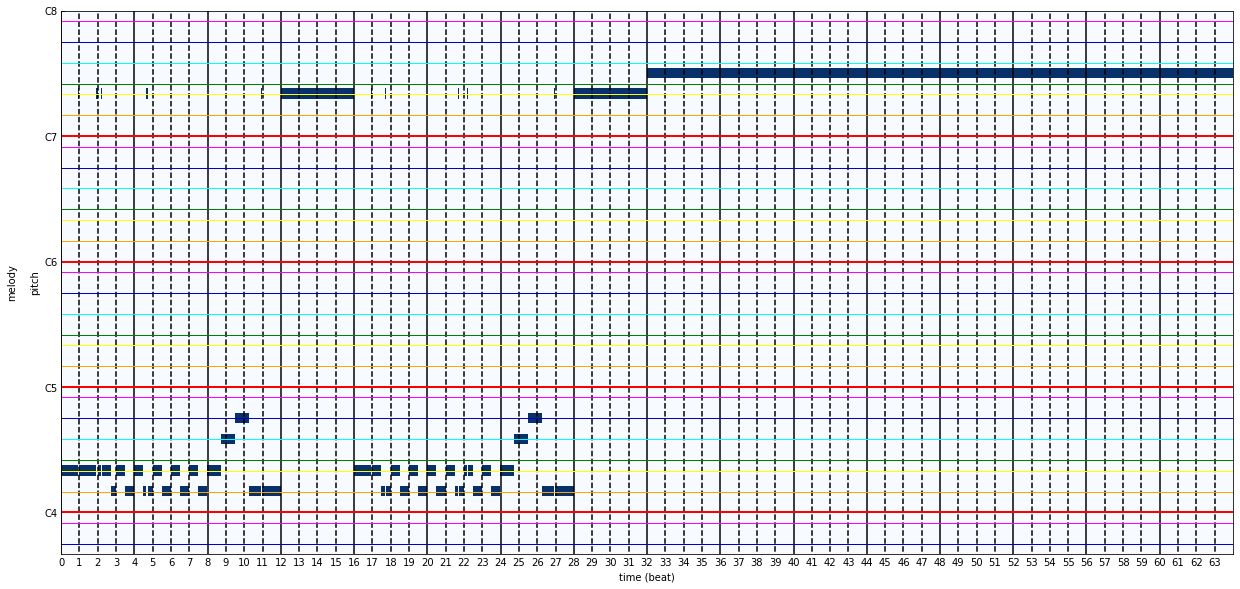

In [37]:
bundle = Bundle(bundle_dict = {
    'melody': org_batch.melody[batch_id],
    'chord': org_batch.chord[batch_id],
    'meta': org_batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, 67]
ppr = bundle.get_ppr()
grid_plot(ppr.tracks[0], beat_resolution=bundle.meta.beat_resolution)

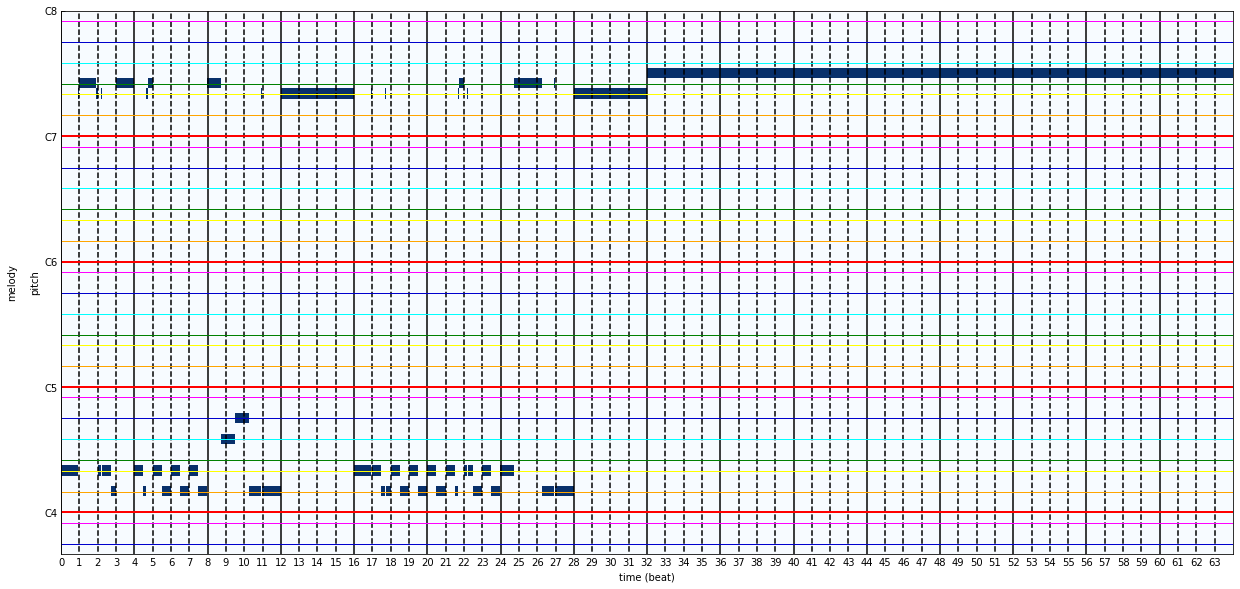

In [38]:
bundle = Bundle({
    'melody': batch.melody[batch_id],
    'chord': batch.chord[batch_id],
    'meta': batch.meta[batch_id]
})
bundle.meta.melody_pitch_range = [0, 67]
ppr = bundle.get_ppr()
grid_plot(ppr.tracks[0], beat_resolution=bundle.meta.beat_resolution)

### BarsOrderPredictionの作成

GANによる学習を優先

### ConditionPredictionの作成

GANによる学習を優先

# 事前学習の実行と結果の表示・保存

## 事前学習

### DataLoaderを作成

In [39]:
batch_size = 11
dataloaders_dict = {
    'train': TheorytabDataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': TheorytabDataLoader(val_dataset, batch_size=batch_size, shuffle=True),
    'test': TheorytabDataLoader(test_dataset, batch_size=batch_size/2)
}
print(f"train data size: {len(dataloaders_dict['train'].dataset):<5}, batch num: {len(dataloaders_dict['train']):<5}")
print(f"  val data size: {len(dataloaders_dict['val'].dataset):<5}, batch num: {len(dataloaders_dict['val']):<5}")
print(f" test data size: {len(dataloaders_dict['test'].dataset):<5}, batch num: {len(dataloaders_dict['test']):<5}")

train data size: 13916, batch num: 1392 
  val data size: 2957 , batch num: 296  
 test data size: 523  , batch num: 105  


### モデルの用意

In [40]:
multi_gpu = False
device = torch.device('cuda:2')

multi_gpu = multi_gpu & (device.type == 'cuda')

melody_emb = MelodyEmbeddings(config)
chord_emb = ChordEmbeddings(config)
body = ConditionalBertBody(config, melody_emb, chord_emb,
                           config.melody_pad_id, config.chord_pad_id)
pre_training_models = [
    MaskedNotePrediction(config, body).to(device),
    # BarsOrderPrediction(config, body).to(device),
    # ConditionPrediction(config, body).to(device),
]

if multi_gpu:
    print("Use Multi GPUs")
    pre_training_models = [torch.nn.DataParallel(model, device_ids=[1,3]) for model in pre_training_models]

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': config.adam_lr} for model in pre_training_models
], betas = (config.adam_beta1, config.adam_beta2))

print("Network settings completed")

Network settings completed


### 事前学習の実行
学習中モデルの保存も行いたいので保存用関数もここで定義してしまう  
あとでmelody_embはノイズ発生器に置き換えたいのでsave_bodyはembとattention_listを別々に保存する

In [41]:
def make_state_name(config, model, epoch_num):
    nickname = config.nickname
    model_name = model.__class__.__name__
    E = epoch_num
    H = config.hidden_size
    I = config.intermediate_size
    A = config.attention_layer_num
    AH = config.attention_head_num
    
    state_name = f"{nickname}:{model_name}:E={E}H={H}I={I}A={A}AH={AH}"
    
    if issubclass(model.__class__, PreTrainingModel):
        state_name += model.condition_str
    
    return state_name

def save_model(config, model, epoch_num, directory):
    state_name = f"{make_state_name(config, model, epoch_num)}.pth"
    state_path = os.path.join(directory, state_name)
    torch.save(model.state_dict(), state_path)
    print(f"{state_name} saved")
    return state_name

def load_model(model, state_name, directory):
    file_path = os.path.join(directory, state_name)
    state_dict = torch.load(file_path)
    model.load_state_dict(state_dict)
    return model

def save_body(config, body, epoch_num, directory):
    input_emb_name = save_model(config, body.input_embeddings, epoch_num, output_dir)
    condition_emb_name = save_model(config, body.condition_embeddings, epoch_num, output_dir)
    bert_stack_name = save_model(config, body.conditional_bert_stack, epoch_num, output_dir)
    return AttrDict({
        "input_embeddings": input_emb_name, 
        "condition_embeddings": condition_emb_name, 
        "conditional_bert_stack": bert_stack_name
    })

def load_body(config, input_emb, condition_emb, directory):
    state_name_dict = config["state_names"]
    
    input_emb_name = state_name_dict['input_embeddings']
    condition_emb_name = state_name_dict['condition_embeddings']
    bert_stack_name = state_name_dict['conditional_bert_stack']
    
    input_emb = load_model(input_emb, input_emb_name, directory)
    condition_emb = load_model(condition_emb, condition_emb_name, directory)
    body = ConditionalBertBody(config, melody_emb, chord_emb, 
                               config.melody_pad_id, config.chord_pad_id)
    body.conditional_bert_stack = load_model(body.conditional_bert_stack, 
                                             bert_stack_name, directory)
    
    return body

def save_config(config, directory, state_names_dict={}):
    delta = datetime.timezone(datetime.timedelta(hours=9))
    now = datetime.datetime.now(delta).strftime('%Y-%m-%d_%H:%M')
    file_name = f"{config.nickname}:config@{now}.json"
    file_path = os.path.join(directory, file_name)
    config['state_names'] = dict(state_names_dict)
    json.dump(dict(config), 
              open(file_path, "w"), 
              ensure_ascii=False, 
              indent=4, 
              sort_keys=True, 
              separators=(',', ': '))
    print(f"{file_name} saved")
    return file_name

def load_config(config_name, directory):
    file_path = os.path.join(directory, config_name)
    config = AttrDict(json.load(open(file_path, "r")))
    return config

動作確認

save_model(config, mnp, 0, output_dir)  
state_names_dict = save_body(config, body, 0, output_dir)  
config_path = save_config(config, output_dir, state_names_dict=state_names_dict)  
body_trained = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), output_dir)

In [42]:
def pre_train(body, pre_training_models, dataloaders_dict, optimizer, epoch_num, output_dir, 
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3): 
    torch.backends.cudnn.benchmark = True
    
    if start_epoch < 2:
        for model in pre_training_models:
            for phase in ['train', 'val']:
                model.loss_dict[phase] = []
                model.acc_dict[phase] = []
    
    for epoch in range(start_epoch, epoch_num+1):
        if (epoch-1) % clear_disp_epoch_period == 0:
            clear_output()
            
        print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
        t_epoch_start = time.time()
        
        for model in pre_training_models:
            print(f"----- Pre-training task start -----")
            print(f"Pre-training model: {model.__class__.__name__}")
            t_model_start = time.time()
            
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                    print("\nValidating...")
                
                model_loss = 0.0
                model_acc = 0.0
                
                t_iter_start = time.time()
                batch_num = len(dataloaders_dict[phase])
                for iteration, batch in enumerate(dataloaders_dict[phase], 1):
                    optimizer.zero_grad()
                    
                    batch.melody = batch.melody.to(device)
                    batch.chord = batch.chord.to(device)
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        loss, acc = model(batch)
                        model_loss += loss.item()
                        model_acc += acc.item()
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            if (iteration % report_period == 0):
                                duration = time.time() - t_iter_start
                                print(f"Iteration {iteration:>5}/{batch_num:<5} | Loss: {loss:.4f} | Acc: {acc:.4f} | {duration:.4f}[sec]")
                                t_iter_start = time.time()
                
                model_loss /= batch_num
                model_acc /= batch_num
                model.loss_dict[phase].append(model_loss)
                model.acc_dict[phase].append(model_acc)
                
                print(f"Average result of {model.__class__.__name__} in {phase:^5} phase")
                print(f"Epoch {epoch:>3} / {epoch_num:<3} | Loss: {model_loss:.4f} | Acc: {model_acc:.4f}")
            
            print(f"\nPre-training epoch finished in {time.time() - t_model_start:.4f}[sec]\n")
        
        epoch_duration = time.time() - t_epoch_start
        print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
        remain_sec = epoch_duration * (epoch_num - epoch)
        print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
        
        # チェックポイントモデルの保存
        if (epoch % save_epoch_period == 0):
            print("start saving models")
            save_body(config, body, epoch, output_dir)
            for model in pre_training_models:
                save_model(config, model, epoch, output_dir)
            print("")
    
    print("All Pre-training Finished!")
    return body, pre_training_models

In [ ]:
epoch_num = 100
body_trained, models_trained = pre_train(
    body=body,
    pre_training_models=pre_training_models,
    dataloaders_dict=dataloaders_dict,
    optimizer=optimizer,
    epoch_num=epoch_num,
    output_dir=output_dir,
    report_period=len(dataloaders_dict['train']) // 5,
    save_epoch_period = 10
)

## 事前学習結果の表示

In [ ]:
task_num = len(models_trained)
fig, axs = plt.subplots(task_num, 2, figsize=(12, task_num*6))

for m, model in enumerate(models_trained):
    train_loss = model.loss_dict['train']
    val_loss = model.loss_dict['val']
    train_acc = model.acc_dict['train']
    val_acc = model.acc_dict['val']
    x = np.arange(len(train_loss))
    
    if task_num == 1:
        ax_loss = axs[0]
        ax_acc = axs[1]
    else:
        ax_loss = axs[m][0]
        ax_acc = axs[m][1]
        
    ax_loss.plot(x, train_loss, label='train', linewidth=1.5)
    ax_loss.plot(x, val_loss, label='val', linewidth=1.5)
    ax_loss.legend(loc='upper right')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.set_title(f"{model.__class__.__name__} Loss")

    ax_acc.plot(x, train_acc, label='train', linewidth=1.5)
    ax_acc.plot(x, val_acc, label='val', linewidth=1.5)
    ax_acc.legend(loc='upper right')
    ax_acc.set_xlabel('epoch')
    ax_acc.set_ylabel('acc')
    ax_acc.set_title(f"{model.__class__.__name__} Acc")

plt.show()

## 事前学習済みモデルの保存と読込み

In [ ]:
state_names_dict = save_body(config, body_trained, epoch_num, output_dir)

pre_training_state_names = []
for model_trained in models_trained:
    state_name = save_model(config, model_trained, epoch_num, output_dir)
    pre_training_state_names.append(state_name)

state_names_dict['masked_note_prediction'] = pre_training_state_names[0]

config_file_name = save_config(config, output_dir, state_names_dict)

In [ ]:
config = load_config(config_file_name, directory)

body_trained = load_body(config, MelodyEmbeddings(config), ChordEmbeddings(config), directory)

models_trained = [
    load_model(
        MaskedNotePrediction(config, body_trained), 
        config.state_names.masked_note_prediction,
        output_dir),
]

## テストデータでのチェック

In [ ]:
model = models_trained[0]

device = torch.device("cuda:3")
model = model.to(device)

print(f"Start task using test data by {model.__class__.__name__}")
with Timer():
    test_acc = 0.
    model.eval()
    for batch in dataloaders_dict['test']:
        with torch.set_grad_enabled(False):
            batch.melody = batch.melody.to(device)
            batch.chord = batch.chord.to(device)
            _, acc = model(batch) # 評価モード時はlossが出ない．たぶん．
            test_acc += acc

data_num = len(dataloaders_dict['test'].dataset)
batch_num = len(dataloaders_dict['test'])
test_acc /= batch_num

print(f"Accuracy result by {data_num} test data: {test_acc}")